# Fase 0.0: Entrenar y ejecutar una CNN básica para clasificación de imágenes hiperespectrales

In [1]:
# Imports

import math,random,struct,os,time,sys
import numpy as np
import torch
import torch.nn as nn
import torch.onnx
from torchvision import models
from torch.utils.data import Dataset,DataLoader
import onnx
import onnxruntime as ort
from sklearn import preprocessing
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import time

## 1. Definición de funciones

### 1.1. Leer y mostrar el dataset

In [2]:
# Leer imágenes en formato raw

def read_raw(fichero):
  (B,H,V)=np.fromfile(fichero,count=3,dtype=np.uint32)
  datos=np.fromfile(fichero,count=B*H*V,offset=3*4,dtype=np.int32)
  print('* Read dataset:',fichero)
  print('  B:',B,'H:',H,'V:',V)
  print('  Read:',len(datos))
  # para normalizar el dataset en [0:1] (en esta red no hace falta)
  # datos=preprocessing.minmax_scale(datos)
  datos=datos.reshape(V,H,B)
  datos=torch.FloatTensor(datos)
  return(datos,H,V,B)

def save_raw(output,H,V,B,filename):
  try:
    f=open(filename,"wb")
  except IOError:
    print('No puedo abrir ',filename)
    exit(0)
  else:
    f.write(struct.pack('i',B))
    f.write(struct.pack('i',H))
    f.write(struct.pack('i',V))
    output=output.reshape(H*V*B)
    for i in range(H*V*B):
      f.write(struct.pack('i',np.int(output[i])))
    f.close()
    print('* Saved file:',filename)

* Read dataset: ../data/imagenes_rios/oitaven_river.raw
  B: 5 H: 6722 V: 6689
  Read: 224817290


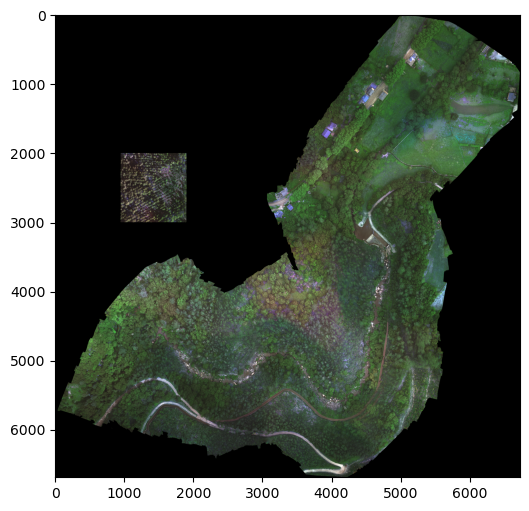

In [3]:
# Mostrar una imagen hiperespectral de ejemplo

DATASET='../data/imagenes_rios/oitaven_river.raw'

(datos,H,V,B)=read_raw(DATASET)

# Seleccionar bandas representativas
bandas_rgb = [0, 1, 2]

# Extraer las bandas seleccionadas
imagen_rgb = datos[:, :, bandas_rgb]

# Normalizar la imagen
imagen_rgb = imagen_rgb.numpy()
imagen_rgb = (imagen_rgb - imagen_rgb.min()) / (imagen_rgb.max() - imagen_rgb.min())

# Mostrar la imagen
plt.figure(figsize=(6, 6))
plt.imshow(imagen_rgb)
plt.show()

In [3]:
# Leer imágenes en formato pgm

def read_pgm(fichero):
  try:
    pgmf=open(fichero,"rb")
  except IOError:
    print('No puedo abrir ',fichero)
  else:
    assert pgmf.readline().decode()=='P5\n'
    line=pgmf.readline().decode()
    while(line[0]=='#'):
      line=pgmf.readline().decode()
    (H,V)=line.split()
    H=int(H); V=int(V)
    depth=int(pgmf.readline().decode())
    assert depth<=255
    raster=[]
    for i in range(H*V):
      raster.append(ord(pgmf.read(1)))
    print('* Read GT:',fichero)
    print('  H:',H,'V:',V,'depth:',depth)
    print('  Read:',len(raster))
    return(raster,H,V)

def save_pgm(output,H,V,nclases,filename):
  try:
    f=open(filename,"wb")
  except IOError:
    print('No puedo abrir ',filename)
    exit(0)
  else:
    # f.write(b'P5\n')
    cadena='P5\n'+str(H)+' '+str(V)+'\n'+str(nclases)+'\n'
    f.write(bytes(cadena,'utf-8'))
    f.write(output)
    f.close()
    print('* Saved file:',filename)

* Read GT: ../data/imagenes_rios/oitaven_river.pgm
  H: 6722 V: 6689 depth: 10
  Read: 44963458


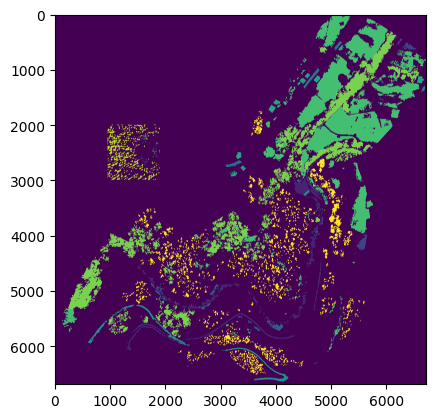

In [4]:
# Mostrar el Ground-Truth de la imagen anterior

GT='../data/imagenes_rios/oitaven_river.pgm'

(imagen_gt, H, V) = read_pgm(GT)

# Convertir la lista a array y redimensionar
imagen_gt = np.array(imagen_gt, dtype=np.uint8).reshape(V, H)

# Mostrar la imagen
plt.imshow(imagen_gt)
plt.show()

In [4]:
# Convertir el Ground-Truth de formato pgm a raw

def save_gt_raw(gt_array, height, width, bands, filename):
    with open(filename, "wb") as f:
        # Cabecera: width, height, bands (1)
        f.write(struct.pack('i', width))
        f.write(struct.pack('i', height))
        f.write(struct.pack('i', bands))
        # Datos planos int32
        gt_array = gt_array.reshape(height * width).astype(np.int32)
        for val in gt_array:
            f.write(struct.pack('i', int(val)))
    print(f'* Saved GT raw: {filename}')

In [9]:
# Ejemplo de uso

GT='../data/imagenes_rios/oitaven_river.pgm'
RAW_GT='../data/imagenes_rios/oitaven_river_converted_gt.raw'

(imagen_gt, H, V) = read_pgm(GT)

# Convertir la lista a array y redimensionar
imagen_gt = np.array(imagen_gt, dtype=np.uint8).reshape(V, H)


save_gt_raw(imagen_gt, H, V, 5, RAW_GT)

* Read GT: ../data/imagenes_rios/oitaven_river.pgm
  H: 6722 V: 6689 depth: 10
  Read: 44963458
* Saved GT raw: ../data/imagenes_rios/oitaven_river_converted_gt.raw


### 1.2. Seleccionar conjuntos de entrenamiento, validación y test

In [5]:
# Seleccionar muestrar para entrenamiento, validación y test

def select_training_samples(truth,H,V,sizex,sizey,porcentaje):
  print('* Select training samples')
  # hacemos una lista con las clases, pero puede haber clases vacias
  nclases=0; nclases_no_vacias=0
  N=len(truth)
  for i in truth:
    if(i>nclases): nclases=i
  print('  nclasses:',nclases)
  lista=[0]*nclases;
  for i in range(nclases):
    lista[i]=[]
  for i in range(int(sizey/2),V-int(sizey/2)-1):
    for j in range(int(sizex/2),H-int(sizex/2)-1):
      ind=i*H+j
      if(truth[ind]>0): lista[truth[ind]-1].append(ind)
  for i in range(nclases):
    random.shuffle(lista[i])
  # seleccionamos muestras para train, validacion y test
  print('  Class  # :   total | train |   val |    test')
  train=[]; val=[]; test=[]
  for i in range(nclases):
    # tot0: numero muestras entrenamiento, tot1: validacion 
    if(porcentaje[0]>=1): tot0=porcentaje[0]
    else: tot0=int(porcentaje[0]*len(lista[i]))
    if(tot0>=len(lista[i])): tot0=len(lista[i])//2
    if(tot0<0 and len(lista[i])>0): tot0=1
    if(tot0!=0): nclases_no_vacias+=1
    if(porcentaje[1]>=1): tot1=porcentaje[1]
    else: tot1=int(porcentaje[1]*len(lista[i]))
    if(tot1>=len(lista[i])-tot0): tot1=(len(lista[i])-tot0)//2
    if(tot1<1 and len(lista[i])>0): tot1=0
    for j in range(len(lista[i])):
      if(j<tot0): train.append(lista[i][j])
      elif(j<tot0+tot1): val.append(lista[i][j])
      else: test.append(lista[i][j])
    print('  Class',f'{i+1:2d}',':',f'{len(lista[i]):7d}','|',f'{tot0:5d}','|',
      f'{tot1:5d}','|',f'{len(lista[i])-tot0-tot1:7d}')
      
  # Modificamos la funcion para obtener el conjunto para inferencia
  # Verificamos si estamos usando el 100% de las muestras para el conjunto de test
  if len(train) == 0 and len(val) == 0:
    # Verificamos las clases presentes en el conjunto de test y actualizamos nclases_no_vacias
    for i in range(nclases):
      if any(truth[idx] == i+1 for idx in test):
        nclases_no_vacias += 1
        
  return(train,val,test,nclases,nclases_no_vacias)

# Extraer una subsección de la imagen
def select_patch(datos,sizex,sizey,x,y):
  x1=x-int(sizex/2); x2=x+int(math.ceil(sizex/2));     
  y1=y-int(sizey/2); y2=y+int(math.ceil(sizey/2));
  patch=datos[:,y1:y2,x1:x2]
  return(patch)

In [6]:
# Manejar datasets en PyTorch

# Seleccionar muestras sin Ground-Truth
class HyperAllDataset(Dataset):
  def __init__(self,datos,samples,H,V,sizex,sizey):
    self.datos=datos; self.samples=samples
    self.H=H; self.V=V; self.sizex=sizex; self.sizey=sizey;
    self.transform=transforms.Compose(
      [transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip()])
    
  def __len__(self):
    return len(self.samples)

  def __getitem__(self,idx):
    datos=self.datos; H=self.H; V=self.V;
    sizex=self.sizex; sizey=self.sizey; 
    x=self.samples[idx]%H; y=int(self.samples[idx]/H)
    patch=select_patch(datos,sizex,sizey,x,y)
    if(AUM==1): patch=self.transform(patch)
    return(patch)

# Seleccionar muestrar con Ground-Truth
class HyperDataset(Dataset):
  def __init__(self,datos,truth,samples,H,V,sizex,sizey):
    self.datos=datos; self.truth=truth; self.samples=samples
    self.H=H; self.V=V; self.sizex=sizex; self.sizey=sizey;
    self.transform=transforms.Compose(
      [transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip()])
    
  def __len__(self):
    return len(self.samples)

  def __getitem__(self,idx):
    datos=self.datos; truth=self.truth; H=self.H; V=self.V;
    sizex=self.sizex; sizey=self.sizey; 
    x=self.samples[idx]%H; y=int(self.samples[idx]/H)
    patch=select_patch(datos,sizex,sizey,x,y)
    if(AUM==1): patch=self.transform(patch)
    # renumeramos porque la red clasifica tambien la clase 0 
    return(patch,truth[self.samples[idx]]-1)

In [7]:
# Seleccionar conjuntos de entrenamiento, validación y test

DATASET='../data/imagenes_rios/oitaven_river.raw'
GT='../data/imagenes_rios/oitaven_river.pgm'

SAMPLES=[0.02,0.01] # [entrenamiento,validacion]: muestras/clase (200,50) o porcentaje (0.02,0.01) 
PAD=1  # hacemos padding en los bordes para aprovechar todas las muestras

(datos,H,V,B)=read_raw(DATASET)
(truth,H1,V1)=read_pgm(GT)

# Durante la ejecucion de la red vamos a coger patches de tamano cuadrado
sizex=32; sizey=32 

# Hacemos padding en el dataset para poder aprovechar hasta el borde
if(PAD):
    datos=torch.FloatTensor(np.pad(datos,((sizey//2,sizey//2),(sizex//2,sizex//2),(0,0)),'symmetric'))
    H=H+2*(sizex//2); V=V+2*(sizey//2)
    truth=np.reshape(truth,(-1,H1))
    truth=np.pad(truth,((sizey//2,sizey//2),(sizex//2,sizex//2)),'constant')
    H1=H1+2*(sizex//2); V1=V1+2*(sizey//2)
    truth=np.reshape(truth,(H1*V1))

# Necesitamos los datos en band-vector para hacer convoluciones
datos=np.transpose(datos,(2,0,1))

# Seleccionar los conjuntos
(train,val,test,nclases,nclases_no_vacias)=select_training_samples(truth,H,V,sizex,sizey,SAMPLES)
dataset_train=HyperDataset(datos,truth,train,H,V,sizex,sizey)
print('  - train dataset:',len(dataset_train))
dataset_test=HyperDataset(datos,truth,test,H,V,sizex,sizey)
print('  - test dataset:',len(dataset_test))

# Dataloader
batch_size=100 # defecto 100
train_loader=DataLoader(dataset_train,batch_size,shuffle=True)
test_loader=DataLoader(dataset_test,batch_size,shuffle=False)

# Si queremos validacion
if(len(val)>0):
    dataset_val=HyperDataset(datos,truth,val,H,V,sizex,sizey)
    print('  - val dataset:',len(dataset_val))
    val_loader=DataLoader(dataset_val,batch_size,shuffle=False)

* Read dataset: ../data/imagenes_rios/oitaven_river.raw
  B: 5 H: 6722 V: 6689
  Read: 224817290
* Read GT: ../data/imagenes_rios/oitaven_river.pgm
  H: 6722 V: 6689 depth: 10
  Read: 44963458
* Select training samples
  nclasses: 10
  Class  # :   total | train |   val |    test
  Class  1 :  309248 |  6184 |  3092 |  299972
  Class  2 :  113324 |  2266 |  1133 |  109925
  Class  3 :   79152 |  1583 |   791 |   76778
  Class  4 :   43861 |   877 |   438 |   42546
  Class  5 :  128022 |  2560 |  1280 |  124182
  Class  6 :   78785 |  1575 |   787 |   76423
  Class  7 : 2428482 | 48569 | 24284 | 2355629
  Class  8 : 1829360 | 36587 | 18293 | 1774480
  Class  9 :  193884 |  3877 |  1938 |  188069
  Class 10 :  863061 | 17261 |  8630 |  837170
  - train dataset: 121339
  - test dataset: 5885174
  - val dataset: 60666


### 1.3. Funciones auxiliares para el proceso

In [6]:
# Pulsando CNLT-C acabamos el entrenamiento y pasamos a testear
def signal_handler(sig, frame):
  print('\n* Ctrl+C. Exit training')
  global endTrain
  endTrain=True

# Actualizar el learning rate manualmente
def update_lr(optimizer,lr):    
  for param_group in optimizer.param_groups:
    param_group['lr']=lr

# Calcular los promedios de precisiones
def accuracy_mean_deviation(OA,AA,aa):
  n=len(OA); nclases=len(aa[0])
  print('* Means and deviations (%d exp):'%(n))
  # medias
  OAm=0; AAm=0; aam=[0]*nclases;
  for i in range(n):
     OAm+=OA[i]; AAm+=AA[i]
     for j in range(1,nclases): aam[j]+=aa[i][j]
  OAm/=n; AAm/=n
  for j in range(1,nclases): aam[j]/=n
  # desviaciones, usamos la formula que divide entre (n-1)
  OAd=0; AAd=0; aad=[0]*nclases
  for i in range(n):
     OAd+=(OA[i]-OAm)*(OA[i]-OAm); AAd+=(AA[i]-AAm)*(AA[i]-OAm)
     for j in range(1,nclases): aad[j]+=(aa[i][j]-aam[j])*(aa[i][j]-aam[j])
  OAd=math.sqrt(OAd/(n-1)); AAd=math.sqrt(AAd/(n-1))
  for j in range(1,nclases): aad[j]=math.sqrt(aad[j]/(n-1))
  for j in range(1,nclases): print('  Class %02d: %02.02f+%02.02f'%(j,aam[j],aad[j]))
  print('  OA=%02.02f+%02.02f, AA=%02.02f+%02.02f'%(OAm,OAd,AAm,AAd))

### 1.4. Construcción de la Red Neuronal Convolucional

In [14]:
# Definición de la CNN

# Convolutional neural network (two convolutional layers y una lineal)
class CNN21(nn.Module):
  def __init__(self,N1,N2,N3,N4,N5,D1,D2):
    super(CNN21,self).__init__()
    self.layer1=nn.Sequential(
      nn.Conv2d(N1,N2,kernel_size=3,stride=1,padding=2),
      nn.BatchNorm2d(N2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,stride=D1))
    self.layer2=nn.Sequential(
      nn.Conv2d(N2,N3,kernel_size=5,stride=1,padding=2),
      nn.BatchNorm2d(N3),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,stride=D2))
    self.fc=nn.Linear(N4,N5)
      
  def forward(self,x):
    out=self.layer1(x)
    out=self.layer2(out)
    out=out.reshape(out.size(0),-1)
    out=self.fc(out)
    return out

## 2. Flujo principal

### 2.1. Configuración de parámetros

In [9]:
# Definición de parámetros

DATASET='../data/imagenes_rios/oitaven_river.raw'
GT='../data/imagenes_rios/oitaven_river.pgm'

EXP=1    # numero de experimentos
EPOCHS=1000 # EPOCHS de entrenamiente del clasificador, default=100
SAMPLES=[0.02,0.01] # [entrenamiento,validacion]: muestras/clase (200,50) o porcentaje (0.02,0.01) 
PAD=1  # hacemos padding en los bordes para aprovechar todas las muestras
ADA=0  # learning rate: 0-fijo, 1-manual, 2-MultiStepLR, 3-CosineAnnealingLR, 4-StepLR
AUM=0  # aumentado: 0-sin_aumentado, 1-con_aumentado
DET=0  # experimentos: 0-aleatorios, 1-deterministas

In [10]:
# Configuración de parámetros

cuda=True if torch.cuda.is_available() else False
# device=torch.device('cuda' if cuda else 'cpu')
# device='cpu'

if torch.backends.cudnn.is_available():
    print('* Activando CUDNN')
    torch.backends.cudnn.enabled=True
    torch.backends.cudnn.beBhmark=True
# Experimentos deterministas o aleatorios
if(DET==1):
    SEED=0
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    if(cuda==False):
        torch.use_deterministic_algorithms(True)
        g=torch.Generator(); g.manual_seed(SEED)
    else:
        torch.backends.cudnn.deterministic=True
        torch.backends.cudnn.benchmark=False

### 2.2. Carga de datos

In [11]:
# Carga de datos

(datos,H,V,B)=read_raw(DATASET)
(truth,H1,V1)=read_pgm(GT)

# Durante la ejecucion de la red vamos a coger patches de tamano cuadrado
sizex=32; sizey=32 

# Hacemos padding en el dataset para poder aprovechar hasta el borde
if(PAD):
    datos=torch.FloatTensor(np.pad(datos,((sizey//2,sizey//2),(sizex//2,sizex//2),(0,0)),'symmetric'))
    H=H+2*(sizex//2); V=V+2*(sizey//2)
    truth=np.reshape(truth,(-1,H1))
    truth=np.pad(truth,((sizey//2,sizey//2),(sizex//2,sizex//2)),'constant')
    H1=H1+2*(sizex//2); V1=V1+2*(sizey//2)
    truth=np.reshape(truth,(H1*V1))
    
# Necesitamos los datos en band-vector para hacer convoluciones
datos=np.transpose(datos,(2,0,1))

* Read dataset: ../data/imagenes_rios/oitaven_river.raw
  B: 5 H: 6722 V: 6689
  Read: 224817290
* Read GT: ../data/imagenes_rios/oitaven_river.pgm
  H: 6722 V: 6689 depth: 10
  Read: 44963458


### 2.3. Selección de conjuntos de entrenamiento, validación y test

In [12]:
# Seleccionar conjuntos de entrenamiento, validación y test
(train,val,test,nclases,nclases_no_vacias)=select_training_samples(truth,H,V,sizex,sizey,SAMPLES)
dataset_train=HyperDataset(datos,truth,train,H,V,sizex,sizey)
print('  - train dataset:',len(dataset_train))
dataset_test=HyperDataset(datos,truth,test,H,V,sizex,sizey)
print('  - test dataset:',len(dataset_test))

# Dataloader
batch_size=100 # defecto 100
train_loader=DataLoader(dataset_train,batch_size,shuffle=True)
test_loader=DataLoader(dataset_test,batch_size,shuffle=False)

# Si queremos validacion
if(len(val)>0):
    dataset_val=HyperDataset(datos,truth,val,H,V,sizex,sizey)
    print('  - val dataset:',len(dataset_val))
    val_loader=DataLoader(dataset_val,batch_size,shuffle=False)

* Select training samples
  nclasses: 10
  Class  # :   total | train |   val |    test
  Class  1 :  309248 |  6184 |  3092 |  299972
  Class  2 :  113324 |  2266 |  1133 |  109925
  Class  3 :   79152 |  1583 |   791 |   76778
  Class  4 :   43861 |   877 |   438 |   42546
  Class  5 :  128022 |  2560 |  1280 |  124182
  Class  6 :   78785 |  1575 |   787 |   76423
  Class  7 : 2428482 | 48569 | 24284 | 2355629
  Class  8 : 1829360 | 36587 | 18293 | 1774480
  Class  9 :  193884 |  3877 |  1938 |  188069
  Class 10 :  863061 | 17261 |  8630 |  837170
  - train dataset: 121339
  - test dataset: 5885174
  - val dataset: 60666


### 2.4. Definición de la CNN

In [16]:
# Definir la CNN

# Hiperparámetros
if(ADA==0): lr=0.001
else: lr=0.001

# Capas de la CNN: Dos capas convolucionales y una lineal
# Capa conv.1
N1=B          # dimension de entrada
D1=2          # decimacion,por defecto 2
HH1=sizex      # lado patches entrada, por defecto 32 (sizex=sizey)
N2=16         # dimension de salida (seleccionada), por defecto 32
H2=int(HH1/D1) # lado patches salida (calculada), por defecto 32 (sizex=sizey)

# Capa conv.2,parametros de entrada N2, H2 vienen dados por la capa anterior
N3=32         # dimension de salida (seleccionada), por defecto 32
D2=2          # decimacion, defecto 2
H3=int(H2/D2) # lado patches salida

# Capa completamente conectada,parametro de entrada N4 viene de la etapa anterior 
N4=H3*H3*N3   # dimension de entrada
N5=nclases    # dimension de salida

# Declaración del modelo
model=CNN21(N1,N2,N3,N4,N5,D1,D2).to(device)

# Función de pérdida, optimizador y programador de tasas de aprendizaje
# Mean-squared error loss
criterion=nn.CrossEntropyLoss()
# Create an optimizer object: Adam optimizer with learning rate lr
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
# Scheduler (no es estrictamente necesario)
if(ADA==2): scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[EPOCHS//2,(5*EPOCHS)//6],gamma=0.1)
elif(ADA==3): scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=EPOCHS,eta_min=0, verbose=True)
elif(ADA==4): scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99, verbose=True)
else: pass

### 2.5. Entrenamiento del modelo

In [18]:
# Entrenamiento del modelo

global endTrain
endTrain=False

# signal.signal(signal.SIGINT,signal_handler)
total_step=len(train_loader)
for epoch in range(EPOCHS):
    for i,(inputs,labels) in enumerate(train_loader):
        # Cogemos muestras y etiquetas para entrenar
        inputs=inputs.to(device)
        labels=labels.to(device)
        # Forward pass
        outputs=model(inputs)
        loss=criterion(outputs,labels)

        # Backward and optimize
        # reset the gradients (PyTorch accumulates gradients)
        optimizer.zero_grad()
        # compute accumulated gradients
        loss.backward()
        # perform parameter update based on current gradients
        optimizer.step()

    # si tenemos validacion usamos estas muestras, si no el propio train
    if(len(val)>0):
        if(epoch%10==0 or epoch==EPOCHS-1):
            for i,(inputs,labels) in enumerate(val_loader):
                inputs=inputs.to(device)
                labels=labels.to(device)
                outputs=model(inputs)
                loss_val=criterion(outputs,labels)
            print ('  Epoch: %3d/%d, Loss(train): %.4f, Loss(val): %.4f'
             %(epoch,EPOCHS,loss.item(),loss_val.item()))
    else: 
        if(epoch%10==0 or epoch==EPOCHS-1):
            print ('  Epoch: %3d/%d, Loss: %.4f'%(epoch,EPOCHS,loss.item()))

    # Decay learning rate (lo decrementamos cconforme aumentan las iteraciones)
    if(ADA==1 and (epoch+1)%20==0): lr/=2; update_lr(optimizer,lr)
    elif(ADA>1): scheduler.step()
    if(endTrain): break

KeyboardInterrupt: 

### 2.6. Evaluación del modelo

In [17]:
# Evaluar el comportamiento del modelo

output=np.zeros(H*V,dtype=np.uint8)

# eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
model.eval()
with torch.no_grad():
    correct=0; total=0; recoge=[]
    for(inputs,labels) in test_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs=model(inputs)
        (_,predicted)=torch.max(outputs.data,1)
        correct+=(predicted==labels).sum().item()
        predicted_cpu=predicted.cpu()
        for i in range(len(predicted_cpu)):
            output[test[total+i]]=np.uint8(predicted_cpu[i]+1)
        total+=labels.size(0)
        if(total%100000==0): print('  Test:',total,'/',len(dataset_test))

print('* Accuracy: %02.02f'%(100*correct/total))

  Test: 100000 / 5885174
  Test: 200000 / 5885174
  Test: 300000 / 5885174
  Test: 400000 / 5885174
  Test: 500000 / 5885174
  Test: 600000 / 5885174
  Test: 700000 / 5885174
  Test: 800000 / 5885174
  Test: 900000 / 5885174
  Test: 1000000 / 5885174
  Test: 1100000 / 5885174
  Test: 1200000 / 5885174
  Test: 1300000 / 5885174
  Test: 1400000 / 5885174
  Test: 1500000 / 5885174
  Test: 1600000 / 5885174
  Test: 1700000 / 5885174
  Test: 1800000 / 5885174
  Test: 1900000 / 5885174
  Test: 2000000 / 5885174
  Test: 2100000 / 5885174
  Test: 2200000 / 5885174
  Test: 2300000 / 5885174
  Test: 2400000 / 5885174
  Test: 2500000 / 5885174
  Test: 2600000 / 5885174
  Test: 2700000 / 5885174
  Test: 2800000 / 5885174
  Test: 2900000 / 5885174
  Test: 3000000 / 5885174
  Test: 3100000 / 5885174
  Test: 3200000 / 5885174
  Test: 3300000 / 5885174
  Test: 3400000 / 5885174
  Test: 3500000 / 5885174
  Test: 3600000 / 5885174
  Test: 3700000 / 5885174
  Test: 3800000 / 5885174
  Test: 3900000 / 588

In [18]:
# Precisiones a nivel de clase

correct=0; total=0; AA=0; OA=0
class_correct=[0]*(nclases+1)
class_total=[0]*(nclases+1)
class_aa=[0]*(nclases+1)

for i in test:
    if(output[i]==0 or truth[i]==0): continue
    total+=1; class_total[truth[i]]+=1
    if(output[i]==truth[i]):
        correct+=1
        class_correct[truth[i]]+=1
        
for i in range(1,nclases+1):
    if(class_total[i]!=0): class_aa[i]=100*class_correct[i]/class_total[i]
    else: class_aa[i]=0
    AA+=class_aa[i]
    
OA=100*correct/total; AA=AA/nclases_no_vacias

for i in range(1,nclases+1): print('  Class %02d: %02.02f'%(i,class_aa[i]))
print('* Accuracy (pixels), OA=%02.02f, AA=%02.02f'%(OA,AA))
print('  total:',total,'correct:',correct)

  Class 01: 97.92
  Class 02: 91.38
  Class 03: 60.05
  Class 04: 98.60
  Class 05: 79.68
  Class 06: 89.13
  Class 07: 97.72
  Class 08: 85.79
  Class 09: 95.99
  Class 10: 62.15
* Accuracy (pixels), OA=87.92, AA=85.84
  total: 5885174 correct: 5174436


### 2.7. Guardar la salida y el modelo

In [19]:
# Guardar la salida

if(PAD):
    output=np.reshape(output,(-1,H1))
    output=output[sizey//2:V1-sizey//2,sizex//2:H1-sizex//2]
    H1=H1-2*(sizex//2); V1=V1-2*(sizey//2)
    output=np.reshape(output,(H1*V1))

save_pgm(output,H1,V1,nclases,'../results/predictions/output_cnn21.pgm')
    
# Save the model checkpoint
torch.save(model.state_dict(),'../results/models/model_cnn21.ckpt')
# Save the entire model
torch.save(model, '../results/models/model_cnn21.pth')

* Saved file: ../results/output_cnn21.pgm


* Read GT: ../results/output_cnn21.pgm
  H: 6722 V: 6689 depth: 10
  Read: 44963458


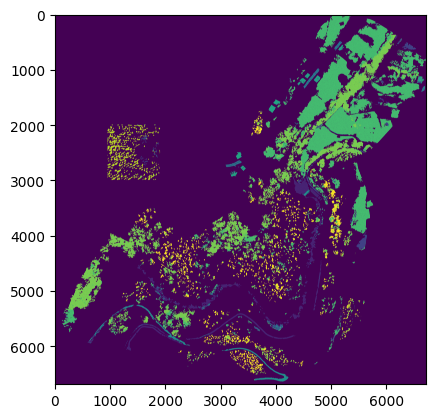

In [20]:
# Mostrar la salida

OUTPUT='../results/predictions/output_cnn21.pgm'

(imagen_output, H1, V1) = read_pgm(OUTPUT)

# Convertir la lista a array y redimensionar
imagen_output = np.array(imagen_output, dtype=np.uint8).reshape(V1, H1)

# Mostrar la imagen
plt.imshow(imagen_output)
plt.show()

## 3. Uso del modelo

In [9]:
# Cargar el modelo cnn21

cuda=True if torch.cuda.is_available() else False
device=torch.device('cuda' if cuda else 'cpu')
device='cpu'

if torch.backends.cudnn.is_available():
    print('* Activando CUDNN')
    torch.backends.cudnn.enabled=True
    torch.backends.cudnn.beBhmark=True

model = torch.load(MODEL, weights_only=False)
model = model.to(device)

In [11]:
# Carga de datos e inferencia

# Medir el tiempo de ejecución
start_time = time.time()

# Definir parámetros y cargar datos

DATASET='../data/imagenes_rios/oitaven_river.raw'
GT='../data/imagenes_rios/oitaven_river.pgm'
MODEL="../results/models/model_cnn21.pth"

# Queremos usar todos los datos para la inferencia
SAMPLES=[0,0]
PAD=1
AUM=0

# Carga de datos
(datos,H,V,B)=read_raw(DATASET)
(truth,H1,V1)=read_pgm(GT)

# Durante la ejecucion de la red vamos a coger patches de tamano cuadrado
sizex=32; sizey=32 

# Hacemos padding en el dataset para poder aprovechar hasta el borde
if(PAD):
    datos=torch.FloatTensor(np.pad(datos,((sizey//2,sizey//2),(sizex//2,sizex//2),(0,0)),'symmetric'))
    H=H+2*(sizex//2); V=V+2*(sizey//2)
    truth=np.reshape(truth,(-1,H1))
    truth=np.pad(truth,((sizey//2,sizey//2),(sizex//2,sizex//2)),'constant')
    H1=H1+2*(sizex//2); V1=V1+2*(sizey//2)
    truth=np.reshape(truth,(H1*V1))
    
# Necesitamos los datos en band-vector para hacer convoluciones
datos=np.transpose(datos,(2,0,1))

# Seleccionar conjunto de test (en este caso es una predicción)
(train,val,test,nclases,nclases_no_vacias)=select_training_samples(truth,H,V,sizex,sizey,SAMPLES)
dataset_test=HyperDataset(datos,truth,test,H,V,sizex,sizey)
print('  - test dataset:',len(dataset_test))

# Dataloader
batch_size=100 # defecto 100
test_loader=DataLoader(dataset_test,batch_size,shuffle=False)

output=np.zeros(H*V,dtype=np.uint8)

# Modo evaluación
model.eval()

# Realizar la predicción
with torch.no_grad():
    total=0
    for (inputs, labels) in test_loader:
        inputs=inputs.to(device)
        outputs=model(inputs)
        (_,predicted)=torch.max(outputs.data,1)
        predicted_cpu=predicted.cpu()
        for i in range(len(predicted_cpu)):
            output[test[total+i]]=np.uint8(predicted_cpu[i]+1)
        total+=labels.size(0)
        if(total%100000==0): print('  Test:',total,'/',len(dataset_test))

end_time = time.time()

print("Prediction time: {:.4f} seconds".format(end_time - start_time))

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [ ]:
# Guardar el output

np.save('../results/predictions/predictions_cnn21.npy', output)

In [ ]:
# Cargar el output

output = np.load('../results/predictions/predictions_cnn21.npy')

In [21]:
# Evaluar el desempeño del modelo

# Precisiones a nivel de clase
correct=0; total=0; AA=0; OA=0
class_correct=[0]*(nclases+1)
class_total=[0]*(nclases+1)
class_aa=[0]*(nclases+1)

for i in test:
    if(output[i]==0 or truth[i]==0): continue
    total+=1; class_total[truth[i]]+=1
    if(output[i]==truth[i]):
          correct+=1
          class_correct[truth[i]]+=1
for i in range(1,nclases+1):
    if(class_total[i]!=0): class_aa[i]=100*class_correct[i]/class_total[i]
    else: class_aa[i]=0
    AA+=class_aa[i]
OA=100*correct/total; AA=AA/nclases_no_vacias

for i in range(1,nclases+1): print('  Class %02d: %02.02f'%(i,class_aa[i]))
print('* Accuracy (pixels) OA=%02.02f, AA=%02.02f'%(OA,AA))
print('  total:',total,'correct:',correct)

  Class 01: 97.94
  Class 02: 91.47
  Class 03: 60.19
  Class 04: 98.62
  Class 05: 79.71
  Class 06: 89.18
  Class 07: 97.74
  Class 08: 85.81
  Class 09: 96.02
  Class 10: 62.18
* Accuracy (pixels) OA=87.95, AA=85.88
  total: 6067179 correct: 5335822


In [22]:
# Guardar la salida

if(PAD):
    output=np.reshape(output,(-1,H1))
    output=output[sizey//2:V1-sizey//2,sizex//2:H1-sizex//2]
    H1=H1-2*(sizex//2); V1=V1-2*(sizey//2)
    output=np.reshape(output,(H1*V1))

save_pgm(output,H1,V1,nclases,'../results/predictions/predictions_model_cnn21.pgm')

* Saved file: ../results/predictions_cnn21.pgm


* Read GT: ../results/predictions_cnn21.pgm
  H: 6722 V: 6689 depth: 10
  Read: 44963458


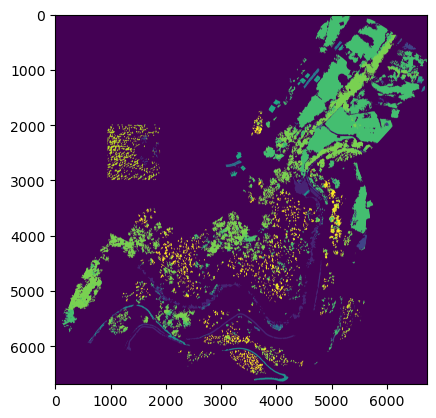

In [23]:
# Mostrar la salida

OUTPUT='../results/predictions/predictions_cnn21.pgm'

(imagen_output, H1, V1) = read_pgm(OUTPUT)

# Convertir la lista a array y redimensionar
imagen_output = np.array(imagen_output, dtype=np.uint8).reshape(V1, H1)

# Mostrar la imagen
plt.imshow(imagen_output)
plt.show()